# Panorama : An Application of Homography

In this section you will learn about the Homography and doing a panorama photo by yourself.

## Waht is homography?

Consider two images of a plane (top of the book) shown in Figure 1. The red dot represents the same physical point in the two images. In computer vision jargon we call these corresponding points. Figure 1. shows four corresponding points in four different colors — red, green, yellow and orange. A **Homography** is a transformation ( a 3×3 matrix ) that maps the points in one image to the corresponding points in the other image.
![img](book.png)
<div  align="center">    
Figure 1:  Two images of a 3D plane ( top of the book ) are related by a Homography
</div>


Now since a homography is a 3×3 matrix we can write it as
<div  align="center">    
$H = \begin{bmatrix}
h_{00} & h_{01} & h_{02}\\ 
h_{10} & h_{11} & h_{12}\\ 
h_{20} & h_{21} & h_{22}
\end{bmatrix}$
</div>
Let us consider the first set of corresponding points — $(x_1,y_1)$ in the first image and $(x_2,y_2)$in the second image. Then,the Homography $H$ maps them in the following way
<div  align="center">    
$\begin{bmatrix}
x_1\\ 
Y_1\\ 
1
\end{bmatrix}
= H
\begin{bmatrix}
x_2\\ 
Y_2\\ 
1
\end{bmatrix}
=
\begin{bmatrix}
h_{00} & h_{01} & h_{02}\\ 
h_{10} & h_{11} & h_{12}\\ 
h_{20} & h_{21} & h_{22}
\end{bmatrix}
\begin{bmatrix}
x_2\\ 
Y_2\\ 
1
\end{bmatrix}$
</div>


![img](book2.png)
<div  align="center">    
Figure 2: One image of a 3D plane can be aligned with another image of the same plane using Homography
</div>

> Reference from https://www.learnopencv.com/homography-examples-using-opencv-python-c/

# Let's do a panorama picture

In [1]:
# install some necessart package
!pip install matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple/
!pip install opencv-python -i https://pypi.tuna.tsinghua.edu.cn/simple/
!pip install opencv-contrib-python -i https://pypi.tuna.tsinghua.edu.cn/simple/

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/


In [2]:
# import those package
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt

## First, input iamge

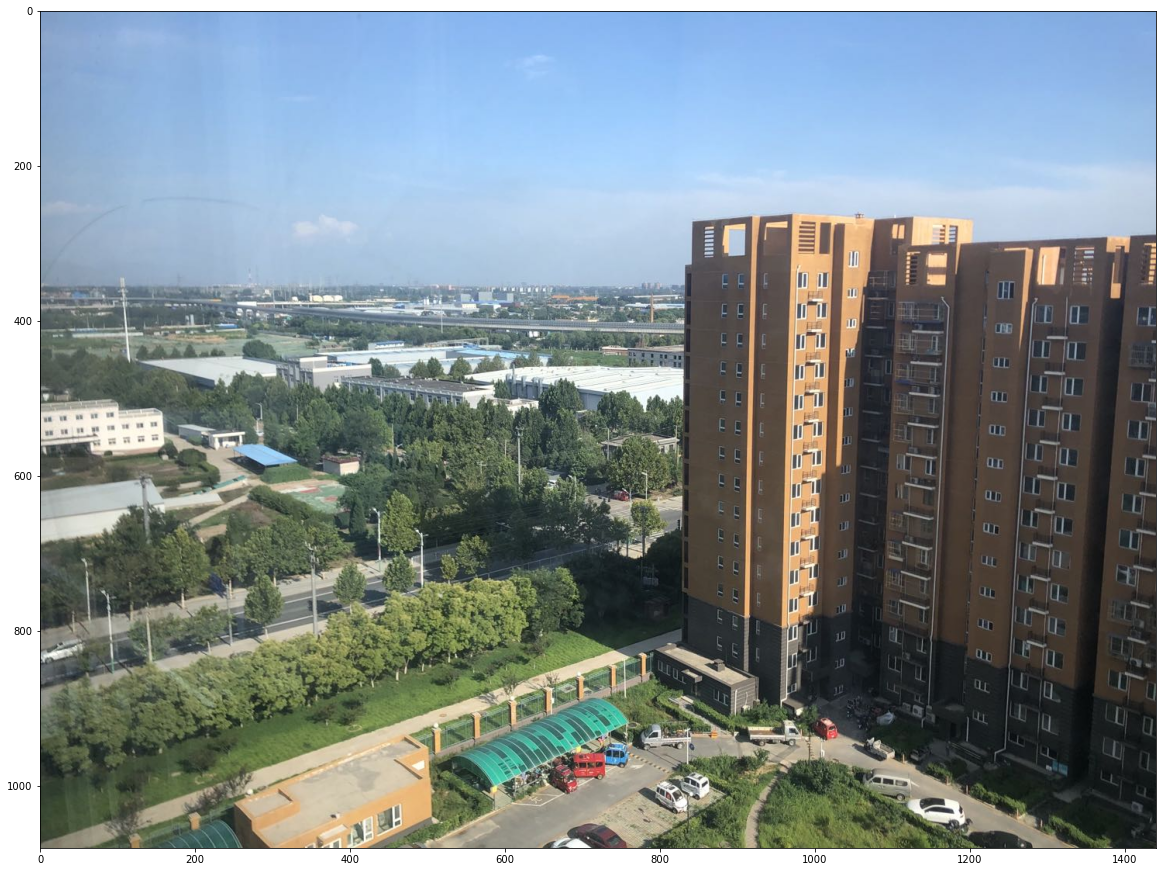

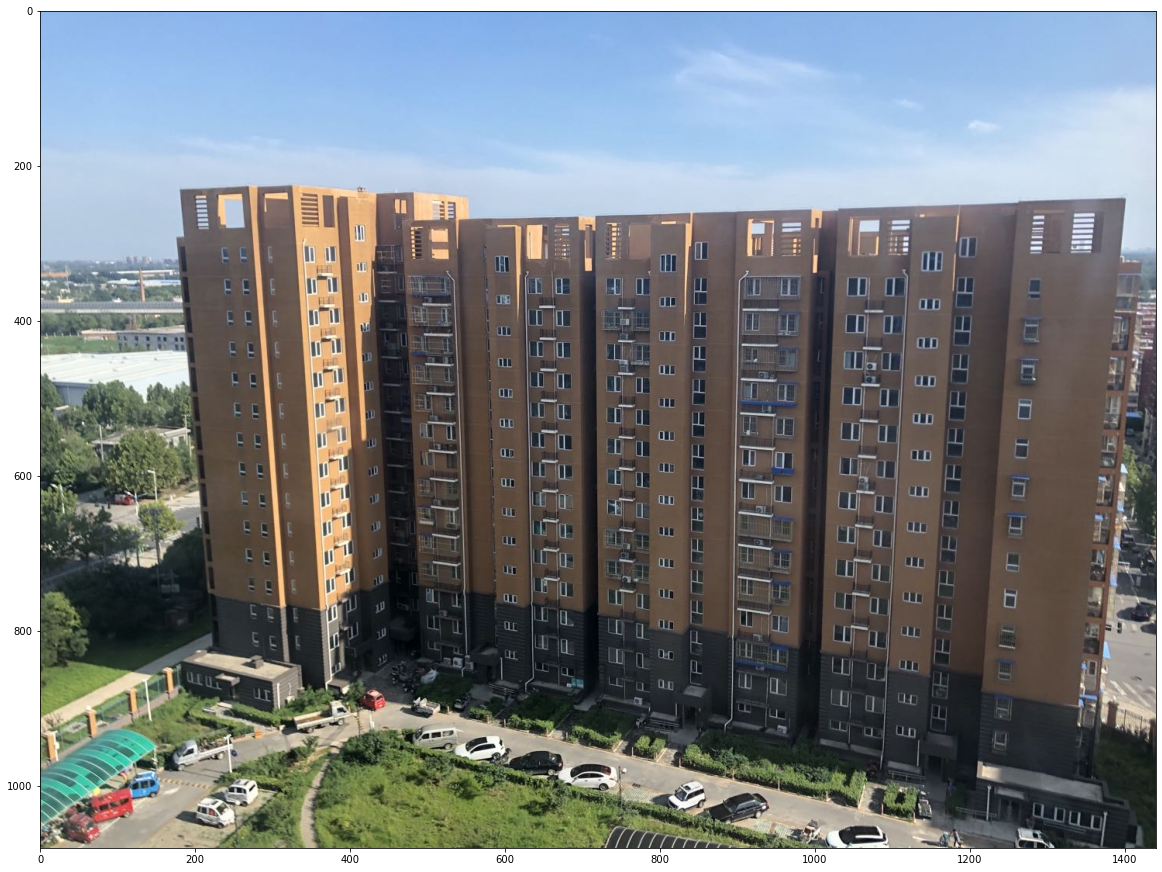

In [6]:
# input your own image in this part
img1 = cv2.imread('pic21.jpg') # change the name into your own picture
rgb_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('pic22.jpg') # change the name into your own picture
rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))## First, input iamge
plt.imshow(rgb_img1)
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(rgb_img2)
plt.show()

## Second, get the match point

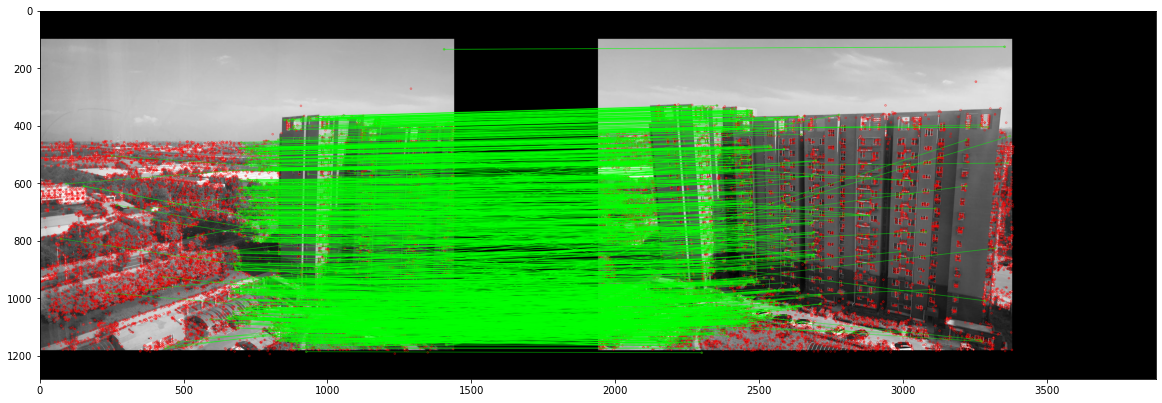

In [7]:
# Add boundry
top, bot, left, right = 100, 100, 0, 500
srcImg = cv2.copyMakeBorder(img1, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
testImg = cv2.copyMakeBorder(img2, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
# conver RGB to gray
img1gray = cv2.cvtColor(srcImg, cv2.COLOR_BGR2GRAY)
img2gray = cv2.cvtColor(testImg, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d_SIFT().create()
# find the keypoints and  descriptors with SIFT（SIFT对特征点附近邻域内高斯图像梯度统计结果的一种表示）
# 计算出图像的关键点和sift特征向量
kp1, des1 = sift.detectAndCompute(img1gray, None)
kp2, des2 = sift.detectAndCompute(img2gray, None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0, 0] for i in range(len(matches))]

good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),singlePointColor=(255, 0, 0),matchesMask=matchesMask,flags=0)

img3 = cv2.drawMatchesKnn(img1gray, kp1, img2gray, kp2, matches, None, **draw_params)

plt.figure(figsize=(20,20))
plt.imshow(img3)
plt.show()



## Finally, caculate homography martirx and get panorama

Need about 1-3 minutes

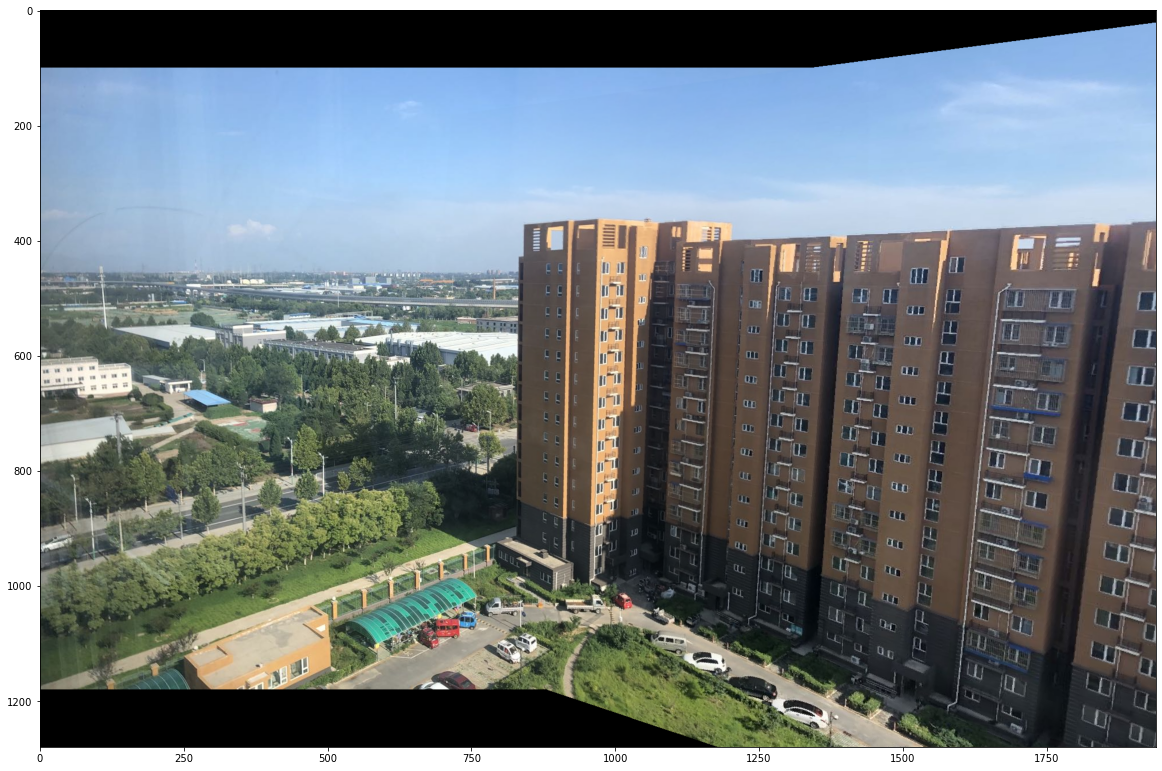

In [8]:
rows, cols = srcImg.shape[:2]
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    # 计算出单应性(homography)矩阵
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    # 获得根据单应性矩阵变化后的图像
    warpImg = cv2.warpPerspective(testImg, np.array(M), (testImg.shape[1], testImg.shape[0]),
                                  flags=cv2.WARP_INVERSE_MAP)

    for col in range(0, cols):
        if srcImg[:, col].any() and warpImg[:, col].any():
            left = col
            break
    for col in range(cols - 1, 0, -1):
        if srcImg[:, col].any() and warpImg[:, col].any():
            right = col
            break
            
    res = np.zeros([rows, cols, 3], np.uint8)
    for row in range(0, rows):
        for col in range(0, cols):
            if not srcImg[row, col].any():
                res[row, col] = warpImg[row, col]
            elif not warpImg[row, col].any():
                res[row, col] = srcImg[row, col]
            else:
                srcImgLen = float(abs(col - left))
                testImgLen = float(abs(col - right))
                alpha = srcImgLen / (srcImgLen + testImgLen)
                res[row, col] = np.clip(srcImg[row, col] * (1 - alpha) + warpImg[row, col] * alpha, 0, 255)

    # opencv is bgr, matplotlib is rgb
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    # show the result
    plt.figure(figsize=(20,20))
    plt.imshow(res)
    plt.show()
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None